# Importing Packages

In [1]:
# Importing necessary packages

import yfinance as yf
import pandas as pd
import numpy as np
import wbdata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime

# For the web scrape
import requests
from bs4 import BeautifulSoup

testing


In [2]:
start_date = '1985-01-01'
end_date = '2024-01-01'
initial_investment = 50000
monthly_investment = 2000

# Data Preperation

### S&P500

In [3]:
# Get historical data for the S&P 500 (^GSPC)
stock = yf.Ticker("^GSPC")
df = stock.history(period="max")

# Keep the first values from the first day of the month
df = df.resample('ME').first()

# Reset the index to move the date from the index to a column
df.reset_index(inplace=True)

# Ensure the 'Date' column is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Keep 2 columns, and only look at dates between 1985 and 2024
df = df[['Date','Open']]
df = df[df['Date'] >= start_date]
df = df[df['Date'] < end_date]

# Create a new column that is a concatenation of the year and month
# This column will be used in later steps as the unique identifier when joining CPI data
df['Year_Month'] = df['Date'].dt.strftime('%Y-%m')
df = df.rename(columns={'Date': 'date', 'Open': 'open', 'Year_Month': 'year_month'})

# display(df)

### CPI Data

In [4]:
# Load CPI data from CSV (adjust path and file name)
cpi_data = pd.read_csv('cpi_monthly_USA.csv')
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
cpi_data['YEAR_MONTH'] = cpi_data['DATE'].dt.strftime('%Y-%m')
cpi_data = cpi_data.rename(columns={'DATE': 'date', 'CPIAUCSL': 'cpi', 'YEAR_MONTH': 'year_month'})

# display(cpi_data)

### Dividend Data

In [5]:

url = 'https://www.multpl.com/s-p-500-dividend-yield/table/by-month'
response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Step 2: Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Step 3: Find the table (adjust the selector as needed)
table = soup.find('table')

# Step 4: Extract the table headers
headers = []
for th in table.find_all('th'):
    headers.append(th.get_text(strip=True))

# Step 5: Extract the table rows
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all(['td', 'th'])
    if len(cells) > 0:
        row = [cell.get_text(strip=True) for cell in cells]
        rows.append(row)

# Step 6: Create a DataFrame
df_dividends = pd.DataFrame(rows[1:], columns=rows[0])

# Convert 'Date' column to datetime
df_dividends['Date'] = pd.to_datetime(df_dividends['Date'], format='%b %d, %Y')
df_dividends['Year'] = df_dividends['Date'].dt.year

# Keep dates up until 2024
df_dividends = df_dividends[df_dividends['Date'] < '2024-01-01']
df_dividends = df_dividends[df_dividends['Date'] > '1985-01-01']

df_dividends['Value'] = df_dividends['Value'].str.replace('%','')

# # Convert 'Value' columns to float
df_dividends['Value'] = pd.to_numeric(df_dividends['Value'])/100

# Let's get to the yearly level
df_dividends = df_dividends.groupby('Year')['Value'].mean().reset_index()

# Let's rename stuff
df_dividends = df_dividends.rename(columns={'Year': 'year', 'Value': 'dividend'})

# display(df_dividends)
# df_dividends.head(10)

### Merge

In [6]:
# We merge the cpi and the s&p data together
merged_df = pd.merge(df, cpi_data[['year_month', 'cpi']], left_on = 'year_month', right_on = 'year_month', how='left')
merged_df['year'] = merged_df['date'].dt.year
merged_df = pd.merge(merged_df, df_dividends[['year', 'dividend']], left_on = 'year', right_on = 'year', how = 'left')
merged_df['dividend'] = np.where(merged_df['date'].dt.month == 1, merged_df['dividend'], 0)
# We create 3 new columns which represent:

# (1) The monthly return as a percentage
merged_df['nominal_return'] = (merged_df['open']-merged_df['open'].shift(1))/merged_df['open'].shift(1)
# (2) The monthly inflation rate
merged_df['inflation_rate'] = (merged_df['cpi']-merged_df['cpi'].shift(1))/merged_df['cpi'].shift(1)
# (3) Given that we know 1 and 2, we can calculate the 'real' return rate
merged_df['real_return'] = (1+merged_df['nominal_return'])/(1+merged_df['inflation_rate'])-1

# Reordering the columns
merged_df = merged_df[['date', 'year_month', 'open', 'nominal_return', 'cpi', 'inflation_rate', 'real_return', 'dividend']]
# display(merged_df)
merged_df.head(10)

,date,year_month,open,nominal_return,cpi,inflation_rate,real_return,dividend
0,1985-01-31 00:00:00-05:00,1985-01,167.199997,NaN,105.7,NaN,NaN,0.041575
1,1985-02-28 00:00:00-05:00,1985-02,179.630005,0.074342,106.3,0.005676,0.068278,0.000000
2,1985-03-31 00:00:00-05:00,1985-03,181.179993,0.008629,106.8,0.004704,0.003907,0.000000
3,1985-04-30 00:00:00-04:00,1985-04,180.660004,-0.002870,107.0,0.001873,-0.004734,0.000000
4,1985-05-31 00:00:00-04:00,1985-05,179.830002,-0.004594,107.2,0.001869,-0.006451,0.000000
5,1985-06-30 00:00:00-04:00,1985-06,189.550003,0.054051,107.5,0.002799,0.051110,0.000000
6,1985-07-31 00:00:00-04:00,1985-07,191.850006,0.012134,107.7,0.001860,0.010254,0.000000
7,1985-08-31 00:00:00-04:00,1985-08,190.919998,-0.004848,107.9,0.001857,-0.006692,0.000000
8,1985-09-30 00:00:00-04:00,1985-09,188.630005,-0.011995,108.1,0.001854,-0.013822,0.000000
9,1985-10-31 00:00:00-05:00,1985-10,182.059998,-0.034830,108.5,0.003700,-0.038388,0.000000


# Analysis

### Investing Options

In [7]:
# Initialize the first row of the new column
merged_df.at[0,'nominal'] = initial_investment
merged_df.at[0,'real'] = initial_investment
merged_df.at[0,'nominal_no_dividend'] = initial_investment
merged_df.at[0,'real_no_dividend'] = initial_investment
merged_df.at[0,'nominal_no_increase'] = initial_investment
merged_df.at[0,'real_no_increase'] = initial_investment
merged_df.at[0,'hypothetical_7'] = initial_investment
merged_df.at[0,'hypothetical_10'] = initial_investment


# We create 6 columns
for i in range(1, len(merged_df)):
    merged_df.at[i,'nominal']             = merged_df.at[i-1,'nominal']*(1+merged_df.at[i,'nominal_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi'] + merged_df.at[i-1,'nominal']*merged_df.at[i,'dividend']
    merged_df.at[i,'real']                = merged_df.at[i-1,'real']*(1+merged_df.at[i,'real_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi'] + merged_df.at[i-1,'real']*merged_df.at[i,'dividend']
    merged_df.at[i,'nominal_no_dividend'] = merged_df.at[i-1,'nominal_no_dividend']*(1+merged_df.at[i,'nominal_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'real_no_dividend']    = merged_df.at[i-1,'real_no_dividend']*(1+merged_df.at[i,'real_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'nominal_no_increase'] = merged_df.at[i-1,'nominal_no_increase']*(1+merged_df.at[i,'nominal_return']) + monthly_investment + merged_df.at[i-1,'nominal_no_increase']*merged_df.at[i,'dividend']
    merged_df.at[i,'real_no_increase']    = merged_df.at[i-1,'real_no_increase']*(1+merged_df.at[i,'real_return']) + monthly_investment + merged_df.at[i-1,'real_no_increase']*merged_df.at[i,'dividend']
    merged_df.at[i,'hypothetical_7']      = merged_df.at[i-1,'hypothetical_7']*(1.00643) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'hypothetical_10']     = merged_df.at[i-1,'hypothetical_10']*(1.00797) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'stagnant_monthly_nominal']     = monthly_investment
    merged_df.at[i,'increasing_monthly_nominal']   = monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']

# display(merged_df)


### Visualizations

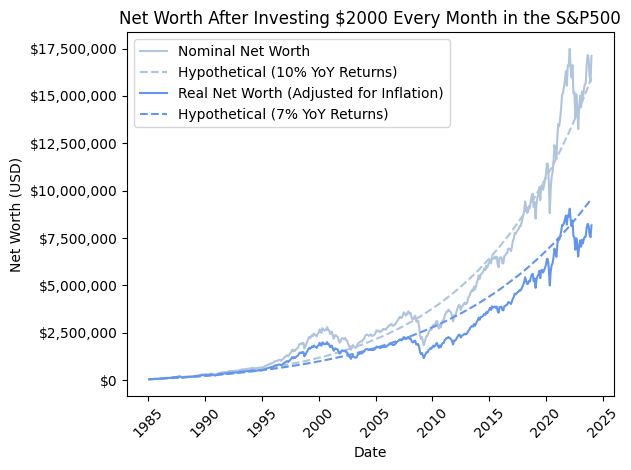

In [8]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot 'open' and 'open_real' against 'date'
ax.plot(merged_df['date'], merged_df['nominal'], color='lightsteelblue',label='Nominal Net Worth')
ax.plot(merged_df['date'], merged_df['hypothetical_10'], color = 'lightsteelblue', linestyle='dashed', label='Hypothetical (10% YoY Returns)')
ax.plot(merged_df['date'], merged_df['real'], color='cornflowerblue', label='Real Net Worth (Adjusted for Inflation)')
ax.plot(merged_df['date'], merged_df['hypothetical_7'], color = 'cornflowerblue', linestyle='dashed', label='Hypothetical (7% YoY Returns)')
# ax.plot(merged_df['date'], merged_df['real_money_3'], color='midnightblue', label='Real Net Worth + Dividends')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Net Worth (USD)')
ax.set_title(f'Net Worth After Investing ${monthly_investment} Every Month in the S&P500')

# Display legends
ax.legend()

# Function to format the y-axis labels with commas
def y_axis_format(x, pos):
    return f'${int(x):,}'

ax.yaxis.set_major_formatter(FuncFormatter(y_axis_format))

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

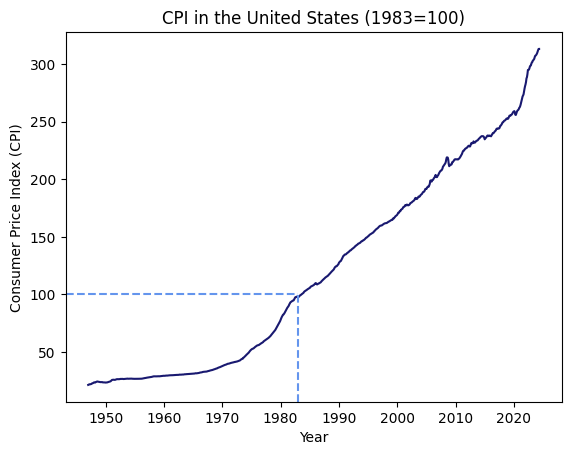

In [9]:
meeting_year = datetime.datetime(1983,1,1)
meeting_CPI = 100

plt.plot(cpi_data['date'], cpi_data['cpi'], color = 'midnightblue')
plt.title('CPI in the United States (1983=100)')
plt.xlabel('Year')
plt.ylabel('Consumer Price Index (CPI)')
plt.axhline(y=meeting_CPI, color='cornflowerblue', linestyle='--', xmax=0.469)
plt.axvline(x=meeting_year, color='cornflowerblue', linestyle='--', ymax=0.29)


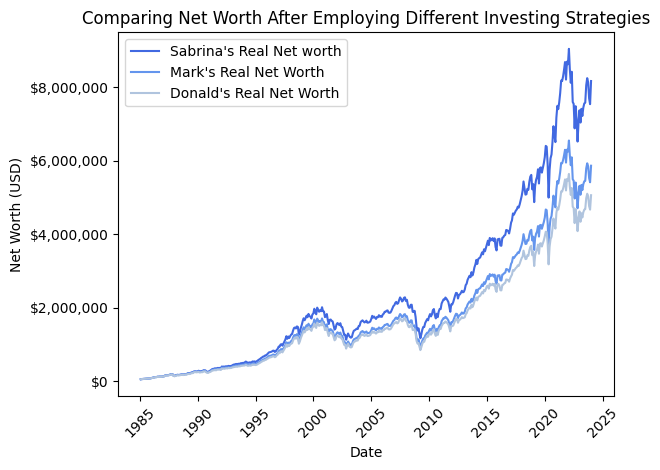

In [10]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot 'open' and 'open_real' against 'date'
ax.plot(merged_df['date'], merged_df['real'], color='royalblue',label='Sabrina\'s Real Net worth')
ax.plot(merged_df['date'], merged_df['real_no_increase'], color = 'cornflowerblue', label='Mark\'s Real Net Worth')
ax.plot(merged_df['date'], merged_df['real_no_dividend'], color = 'lightsteelblue', label='Donald\'s Real Net Worth')
# ax.plot(merged_df['date'], merged_df['real'], color='cornflowerblue', label='Real Net Worth (Adjusted for Inflation)')
# ax.plot(merged_df['date'], merged_df['hypothetical_7'], color = 'cornflowerblue', linestyle='dashed', label='Hypothetical (7% YoY Returns)')
# ax.plot(merged_df['date'], merged_df['real_money_3'], color='midnightblue', label='Real Net Worth + Dividends')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Net Worth (USD)')
ax.set_title(f'Comparing Net Worth After Employing Different Investing Strategies')
# Display legends
ax.legend()

# Function to format the y-axis labels with commas
def y_axis_format(x, pos):
    return f'${int(x):,}'

ax.yaxis.set_major_formatter(FuncFormatter(y_axis_format))

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

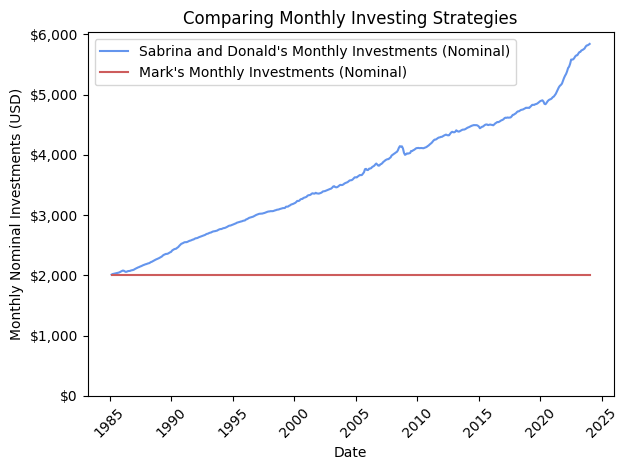

In [11]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot 'open' and 'open_real' against 'date'
ax.plot(merged_df['date'], merged_df['increasing_monthly_nominal'], color='cornflowerblue',label='Sabrina and Donald\'s Monthly Investments (Nominal)')
ax.plot(merged_df['date'], merged_df['stagnant_monthly_nominal'], color = 'indianred', label='Mark\'s Monthly Investments (Nominal)')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Nominal Investments (USD)')
ax.set_title(f'Comparing Monthly Investing Strategies')

# Display legends
ax.legend()

# Function to format the y-axis labels with commas
def y_axis_format(x, pos):
    return f'${int(x):,}'

ax.yaxis.set_major_formatter(FuncFormatter(y_axis_format))

# Show plot
plt.xticks(rotation=45)
ax.set_ylim(ymin=0)
plt.tight_layout()
plt.show()